<a href="https://colab.research.google.com/github/34-anish/Assignment/blob/main/Climate_Change.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets

# hide warnings
import warnings
warnings.simplefilter("ignore")

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

import seaborn as sns



In [133]:
# read the csv file into a DataFrame
df = pd.read_csv("GlobalLandTemperaturesByCity.csv")

# convert first column to DateTime format
df['dt'] = pd.to_datetime(df['dt'])

# set first column (dt) as the index column
df.index = df['dt']
del df['dt']

# dropping AverageTemperatureUncertainty, Latitude and Longitude and combining City and Country into City
df = df.drop({"AverageTemperatureUncertainty", "Latitude", "Longitude"}, 1)
df["City"] = df["City"] + ", " + df["Country"]
df = df.drop("Country", 1)

# removing all rows with NaN values
df = df.dropna()

# get list of all cities in dataset
cities = set(df.City)

In [134]:
# check stationarity in time series data of a given city

def check_stationarity(city_df):
    # method1: plot the time series to check for trend and seasonality
    city_df.plot(figsize=(10, 10))
    
    # method 2: check if histogram fits a Gaussian Curve, then split data into two parts, calculate means and variances and see if they vary
    city_df.hist(figsize=(10, 10))
    plt.show()
    
    X = city_df["AverageTemperature"].values
    split = int(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('mean1=%f, mean2=%f' % (mean1, mean2))
    print('variance1=%f, variance2=%f' % (var1, var2))
    
    # if corresponding means and variances differ slightly (by less than 10), we consider that the time series might be stationary
    if (abs(mean1-mean2) <= 10 and abs(var1-var2) <= 10):
        print("Time Series may be Stationary, since means and variances vary only slightly.\n")
    else:
        print("Time Series may NOT be Stationary, since means and variances vary significantly.\n")
        
    # method3: statistical test (Augmented Dickey-Fuller statistic)
    print("Performing Augmented Dickey-Fuller Test to confirm stationarity...")
    
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    
    p = result[1]
    if (p > 0.05):
        print("Time Series is NOT Stationary, since p-value > 0.05")
        city_df = city_df.diff()  # differencing to make data stationary
        return False
    else:
        print("Time Series is Stationary, since p-value <= 0.05")
        return True

In [135]:
cities


{'Dire Dawa, Ethiopia',
 'Fort Wayne, United States',
 'Nelspruit, South Africa',
 'Chuzhou, China',
 'Jamame, Somalia',
 'Aligarh, India',
 'Baton Rouge, United States',
 'Acarigua, Venezuela',
 'Anqiu, China',
 'Calabozo, Venezuela',
 'Lalitpur, India',
 'Gulu, Uganda',
 'Khandwa, India',
 'Inegol, Turkey',
 'Dumaguete, Philippines',
 'Kassala, Sudan',
 'Cape Town, South Africa',
 'Kusatsu, Japan',
 'Cikupa, Indonesia',
 'Catamarca, Argentina',
 'Chuncheng, China',
 'Lakewood, United States',
 'Coventry, United Kingdom',
 'Cuenca, Ecuador',
 'Kuwana, Japan',
 'Atyrau, Kazakhstan',
 'Kawanishi, Japan',
 'Biysk, Russia',
 'Kemerovo, Russia',
 'Obosi, Nigeria',
 'Dese, Ethiopia',
 'Nijmegen, Netherlands',
 'Gent, Belgium',
 'Fuzhou, China',
 'Livingstone, Zambia',
 'Berkeley, United States',
 'Boulogne Billancourt, France',
 'Jacobabad, Pakistan',
 'Birganj, Nepal',
 'Cologne, Germany',
 'Münster, Germany',
 'Marand, Iran',
 'Mingaora, Pakistan',
 'Imperatriz, Brazil',
 'Malang, Indones

In [136]:
# check stationarity for data of a specific city entered by the user

city_drop_down_menu = widgets.Dropdown(
    options=sorted(list(cities)),
    value='Chula Vista, United States',
     description='City:',
    disabled=False,
)

city_drop_down_menu

Dropdown(description='City:', index=635, options=('A Coruña, Spain', 'Aachen, Germany', 'Aalborg, Denmark', 'A…

In [137]:

chosen_city = city_drop_down_menu.value
city_df = df[df.City == chosen_city].drop("City", 1)

Stationarity Check for Chula Vista, United States


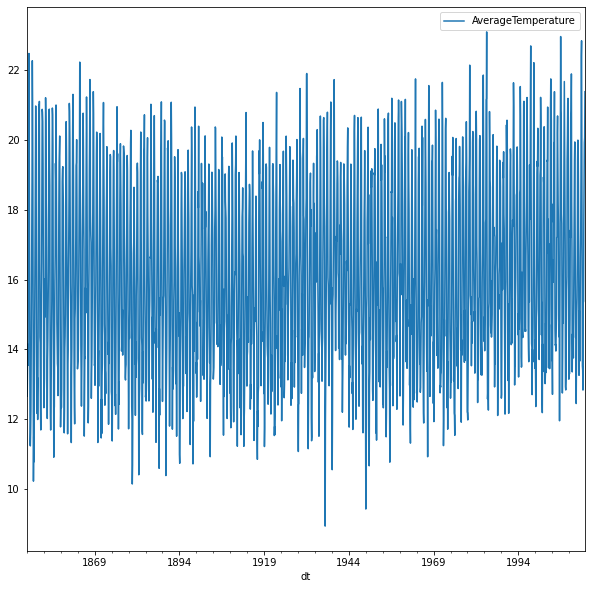

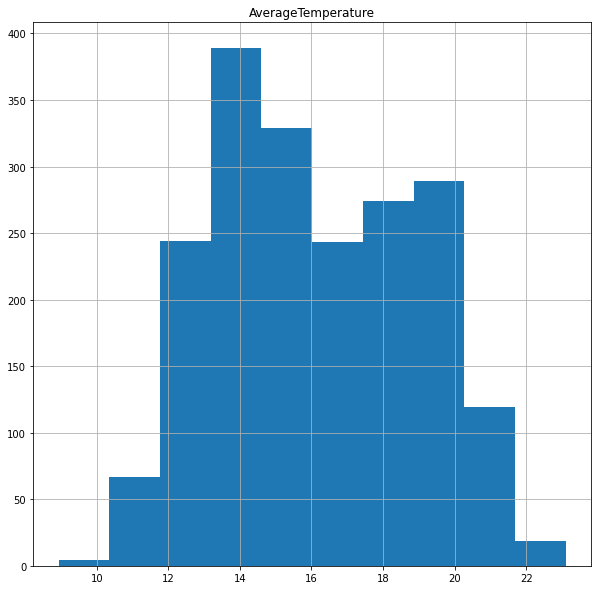

mean1=15.896044, mean2=16.353399
variance1=7.630419, variance2=7.518827
Time Series may be Stationary, since means and variances vary only slightly.

Performing Augmented Dickey-Fuller Test to confirm stationarity...
ADF Statistic: -5.114781
p-value: 0.000013
Time Series is Stationary, since p-value <= 0.05


In [138]:
print ("Stationarity Check for %s" % chosen_city)
is_stationary = check_stationarity(city_df)

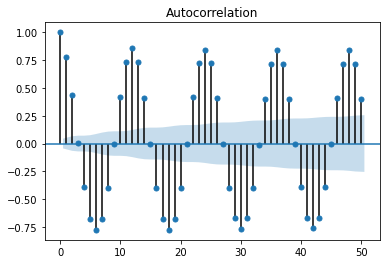

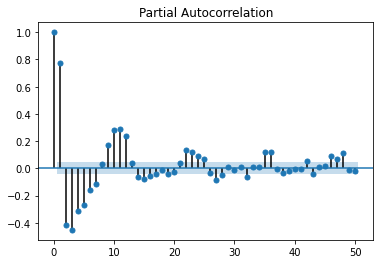

In [139]:
# ACF and PACF plots

plot_acf(city_df,lags = 50)
plot_pacf(city_df,lags = 50)
plt.show()

# setting d value for ARIMA model
if (is_stationary==True):
    d = 0
else:
    d = 1


In [140]:
# Although we can determine p, q values manually by looking at the ACF and PACF plots for a given city, we must automate the process
# To automate the process, we must perform a grid search over different values of p and q and choose the ARIMA model for which the AIC and BIC values are minimum

p_range = q_range = list(range(0,3))  # taking values from 0 to 2

aic_values = []
bic_values = []
pq_values = []

for p in p_range:
    for q in q_range:
        try:
            model = ARIMA(city_df, order=(p, d, q))
            results = model.fit(disp=-1)
            aic_values.append(ARMAResults.aic(results))
            bic_values.append(ARMAResults.bic(results))
            pq_values.append((p, q))
        except:
            pass

best_pq = pq_values[aic_values.index(min(aic_values))]  # (p,q) corresponding to lowest AIC score
print("(p,q) corresponding to lowest AIC score: ", best_pq)

(p,q) corresponding to lowest AIC score:  (2, 2)


In [141]:
# fitting an ARIMA model with chosen p, d, q values and calculating the mean squared error
from sklearn.metrics import mean_absolute_error

arima_model = ARIMA(city_df, order=(best_pq[0], 0, best_pq[1])).fit()
predictions = arima_model.predict(start=0, end=len(city_df)-1)

mse = mean_squared_error(list(city_df.AverageTemperature), list(predictions))
print("Mean Squared Error:", mse)

mae = mean_absolute_error(list(city_df.AverageTemperature), list(predictions))
print("Mean Absolute Error:", mae)

Mean Squared Error: 1.3764727305137388
Mean Absolute Error: 0.9352889155213225


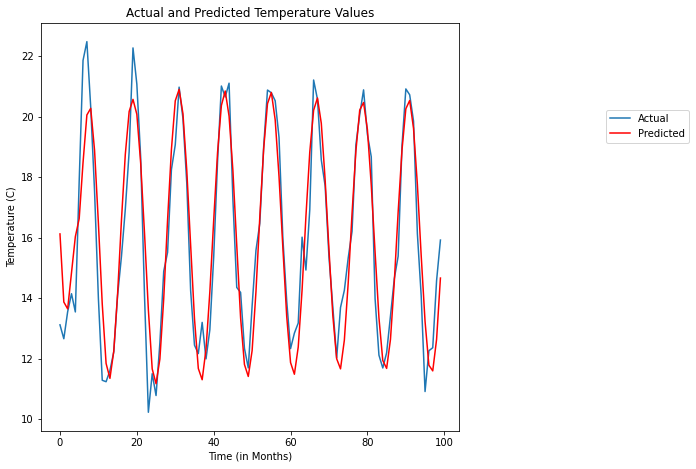

In [142]:
# comparing first 100 predictions with actual values

plt.figure(figsize=(7.5,7.5))
plt.plot(list(city_df.AverageTemperature)[:100], label="Actual")
plt.plot(list(predictions)[:100], 'r', label="Predicted")

plt.xlabel("Time (in Months)")
plt.ylabel("Temperature (C)")
plt.title("Actual and Predicted Temperature Values")

plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8))
plt.show()

In [143]:
# drop-down menu to select number of years for which predictions are required

years_drop_down_menu = widgets.Dropdown(
    options=list(range(1,201)),
    value=10,
    description='No. of Years:',
    disabled=False,
)

years_drop_down_menu

Dropdown(description='No. of Years:', index=9, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,…

In [144]:
num_years = years_drop_down_menu.value
last_month_in_dataset = city_df.index[-1].month  # gets last month in city_df
remaining_months = 12 - last_month_in_dataset  # months left in current year for that city's data
number_of_steps = remaining_months + num_years * 12  # number of steps to make out-of-sample predictions

out_of_sample_forecast = arima_model.forecast(steps=number_of_steps)[0]  # predictions

out_of_sample_forecast = out_of_sample_forecast[remaining_months:]  # excluding predictions for remaining months in current year

In [145]:
# displaying forecasted values for the nth year

months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
i = 0
for x in out_of_sample_forecast[-12:]:  # last year
    print(months[i]+": ", x, 'C')
    i += 1

January:  13.066976398265428 C
February:  12.460918252275345 C
March:  12.836208964763571 C
April:  14.092224824147527 C
May:  15.892484391544532 C
June:  17.754790472519172 C
July:  19.180386004340903 C
August:  19.787529625309727 C
September:  19.41371713335539 C
October:  18.159176307003428 C
November:  16.359993552530902 C
December:  14.498077726969363 C


In [146]:
# plotting the predicted values for the nth year

trace = go.Scatter(
    x = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"],
    y = out_of_sample_forecast[-12:],
    mode = 'lines',
    name = 'Average Temperature'
)

layout = go.Layout(
    title='Predicted Temperatures for the Year %d' % (2013+num_years),
    xaxis=dict(
        title='Year',
    ),
    yaxis=dict(
        title='Temperature (C)',
    )
)
data = [trace]

fig = go.Figure(data=data, layout=layout)
iplot(fig)

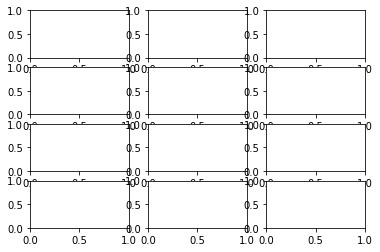

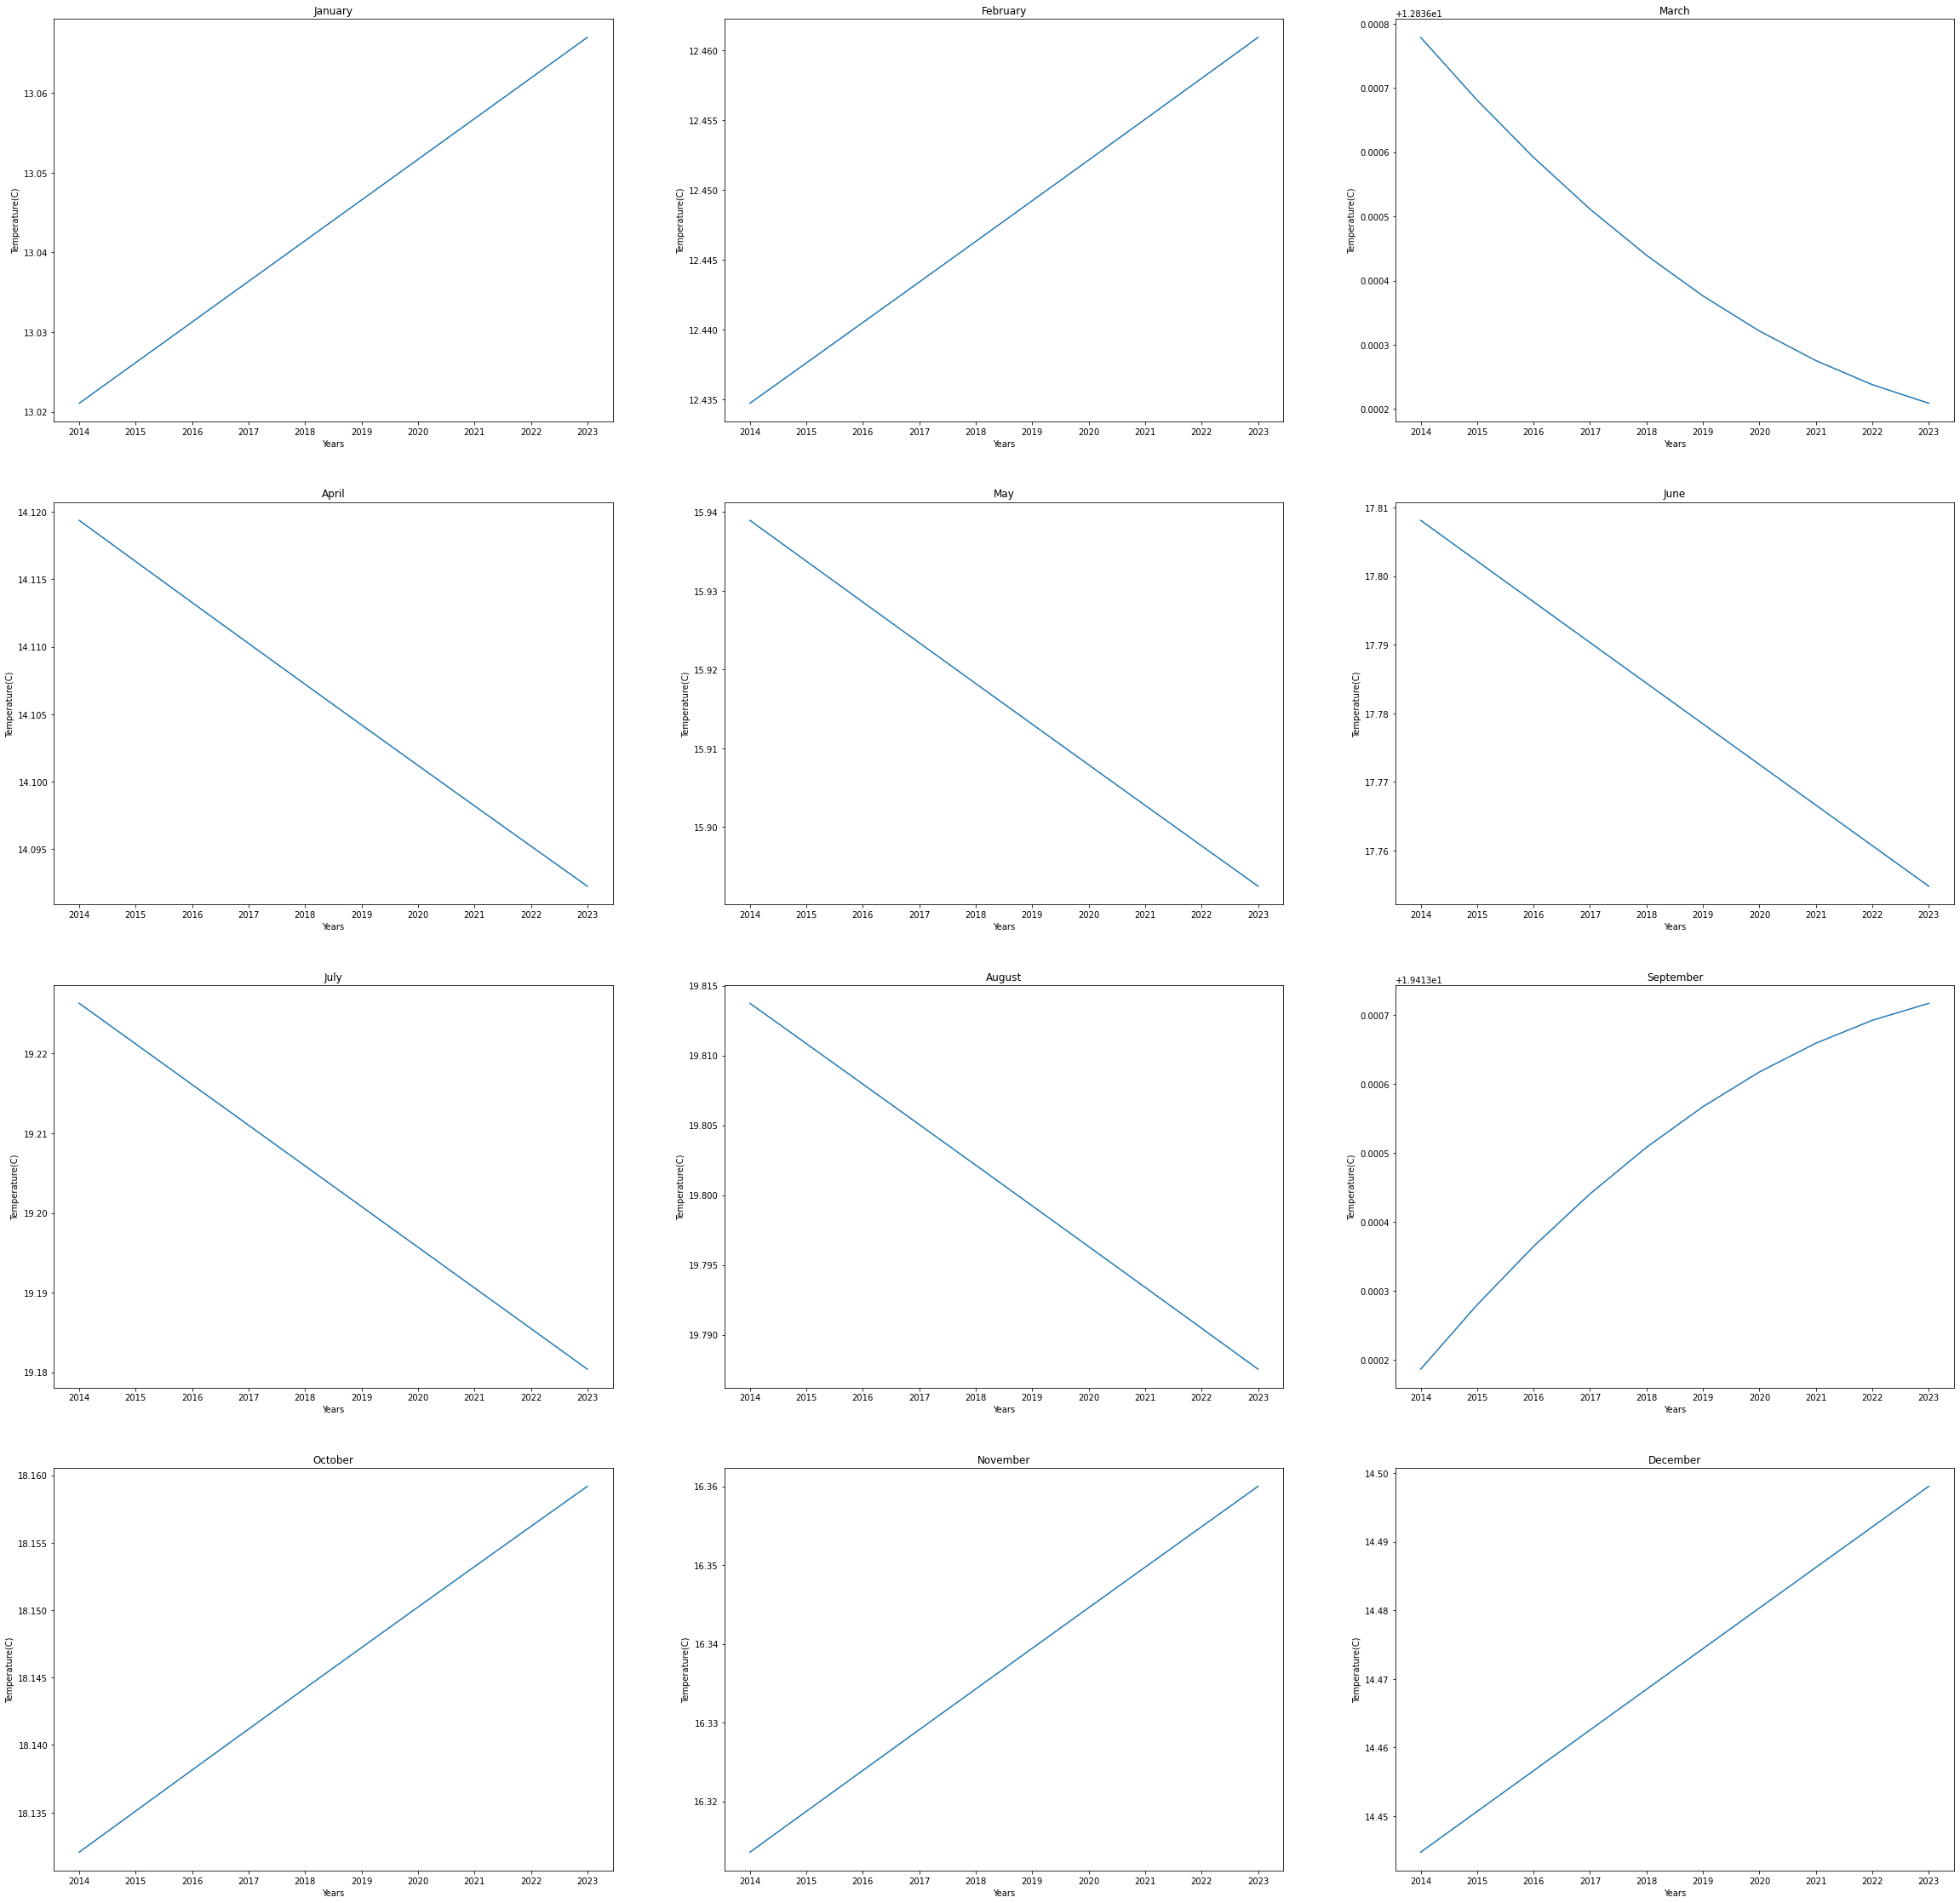

In [147]:
# plotting monthly temperature changes from 2013 to 2013+n years

fig, ax = plt.subplots(nrows=4, ncols=3)

monthly_change = {}

for month in range(12):
    temp = month
    for year in range(num_years):
        if month not in monthly_change:
            monthly_change[month] = [out_of_sample_forecast[temp]]
        else:
            monthly_change[month].append(out_of_sample_forecast[temp])
        temp+=12
plt.figure(figsize=(40,40))
for pos in range(0,12):
    plt.subplot(4,3,pos+1)
    plt.plot(monthly_change[pos])
    plt.xticks(np.array(range(num_years)), [i for i in range(2014,2014+num_years)])
    plt.title(months[pos])
    plt.xlabel('Years')
    plt.ylabel('Temperature(C)')

plt.show()

#Rough

#Changing dt to date type

#Setting the date as the index